In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import (
    RandomForestClassifier, 
    VotingClassifier, 
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)

from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV, 
    train_test_split, 
    cross_val_predict, 
    cross_val_score
)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.svm import LinearSVC, SVC

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from catboost import CatBoostClassifier

#from xgboost import XGBClassifier

## 1. Load data

In [2]:
# Загружаем данные из ga_sessions
stroke = pd.read_csv('data/brain_stroke.csv', sep=',')
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
stroke.shape

(4981, 11)

In [4]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [5]:
stroke.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,4981,4981,4981,4981,4981
unique,2,2,4,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2907,3280,2860,2532,1838


In [6]:
stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [7]:
stroke.duplicated().sum()

0

In [3]:
stroke.columns.to_list()

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [4]:
stroke.ever_married.value_counts()

Yes    3280
No     1701
Name: ever_married, dtype: int64

## 2. Graphs

C:\Users\dimin\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


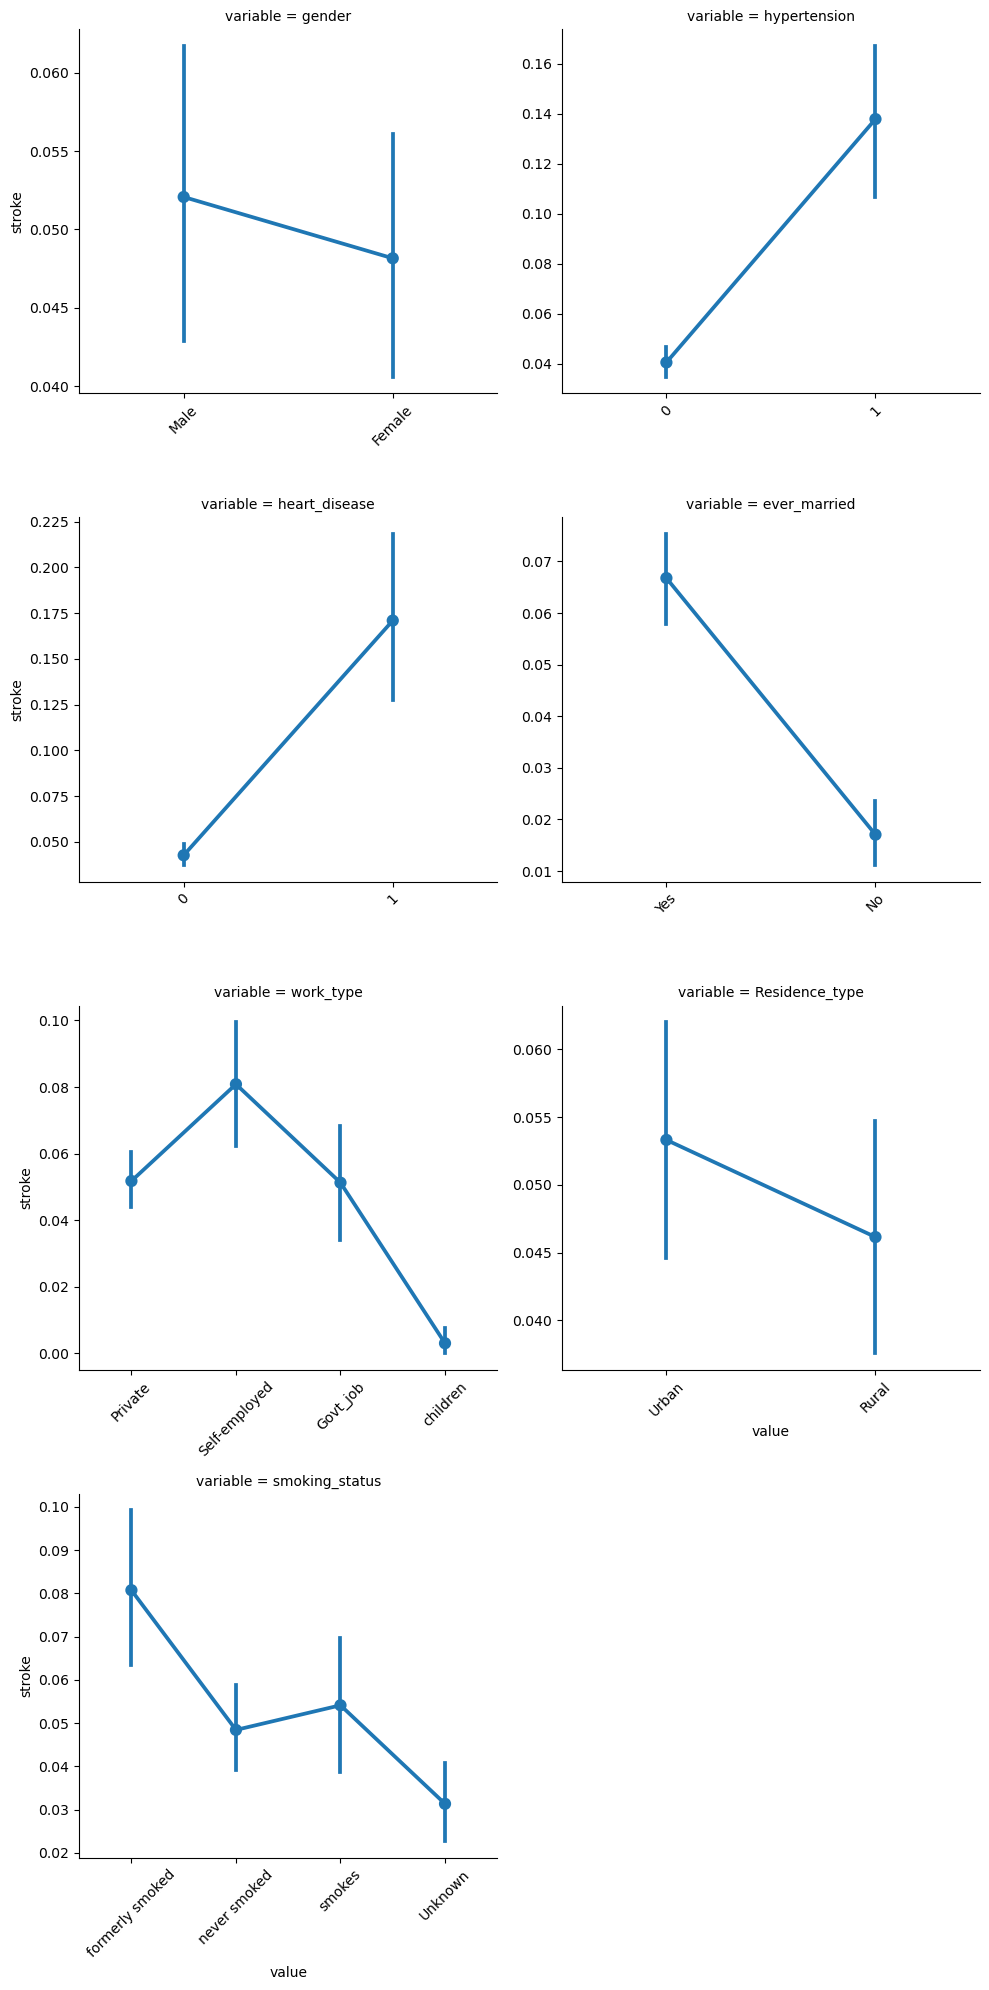

In [5]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

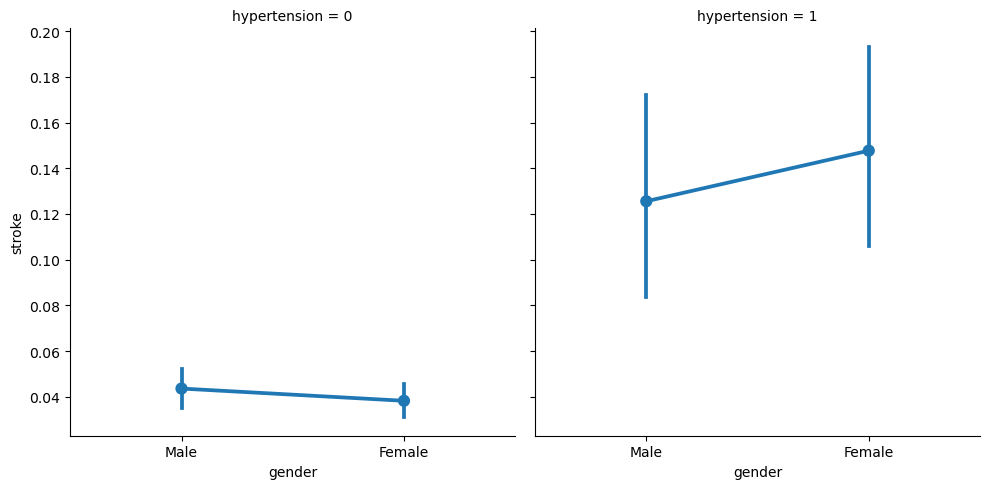

In [19]:
sns.catplot(
    x='gender',
    y='stroke',
    data=stroke,
    col='hypertension',
    kind='point',
);

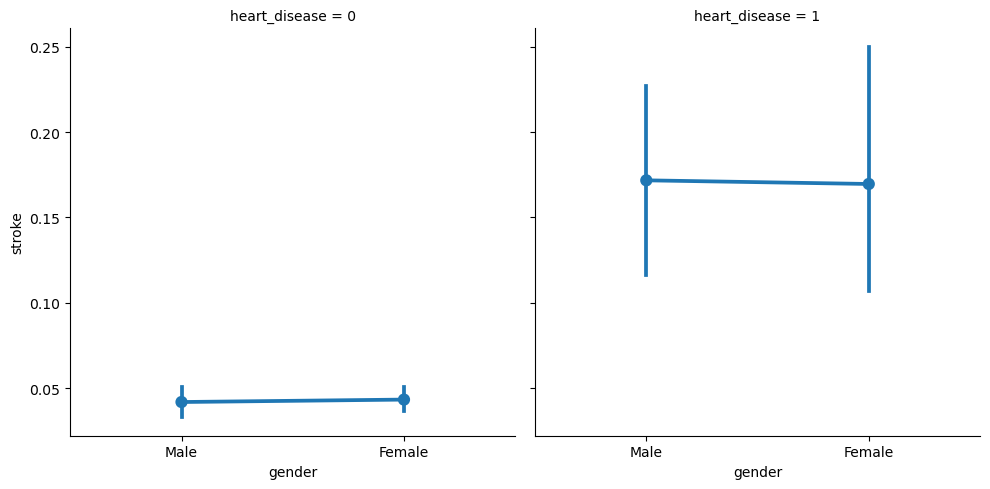

In [20]:
sns.catplot(
    x='gender',
    y='stroke',
    data=stroke,
    col='heart_disease',
    kind='point',
);

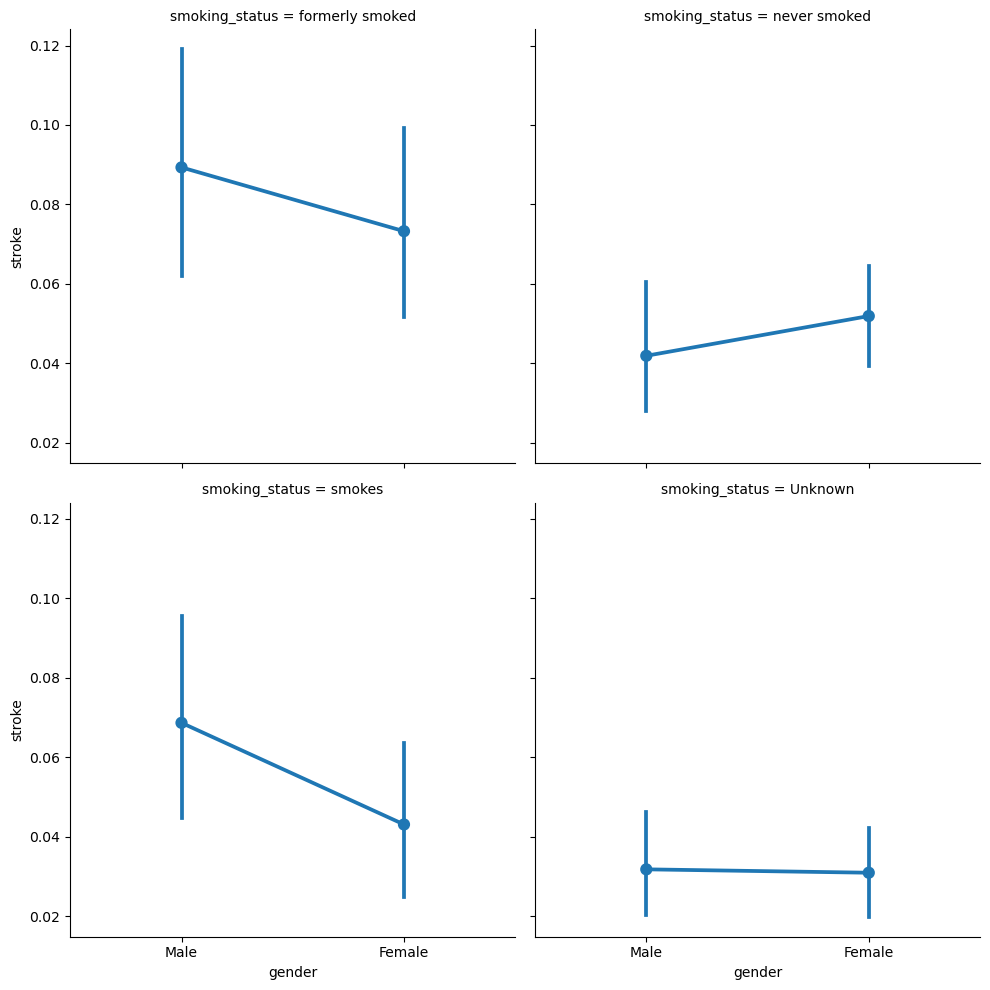

In [22]:
sns.catplot(
    x='gender',
    y='stroke',
    data=stroke,
    col='smoking_status',
    kind='point',
    col_wrap=2,
);

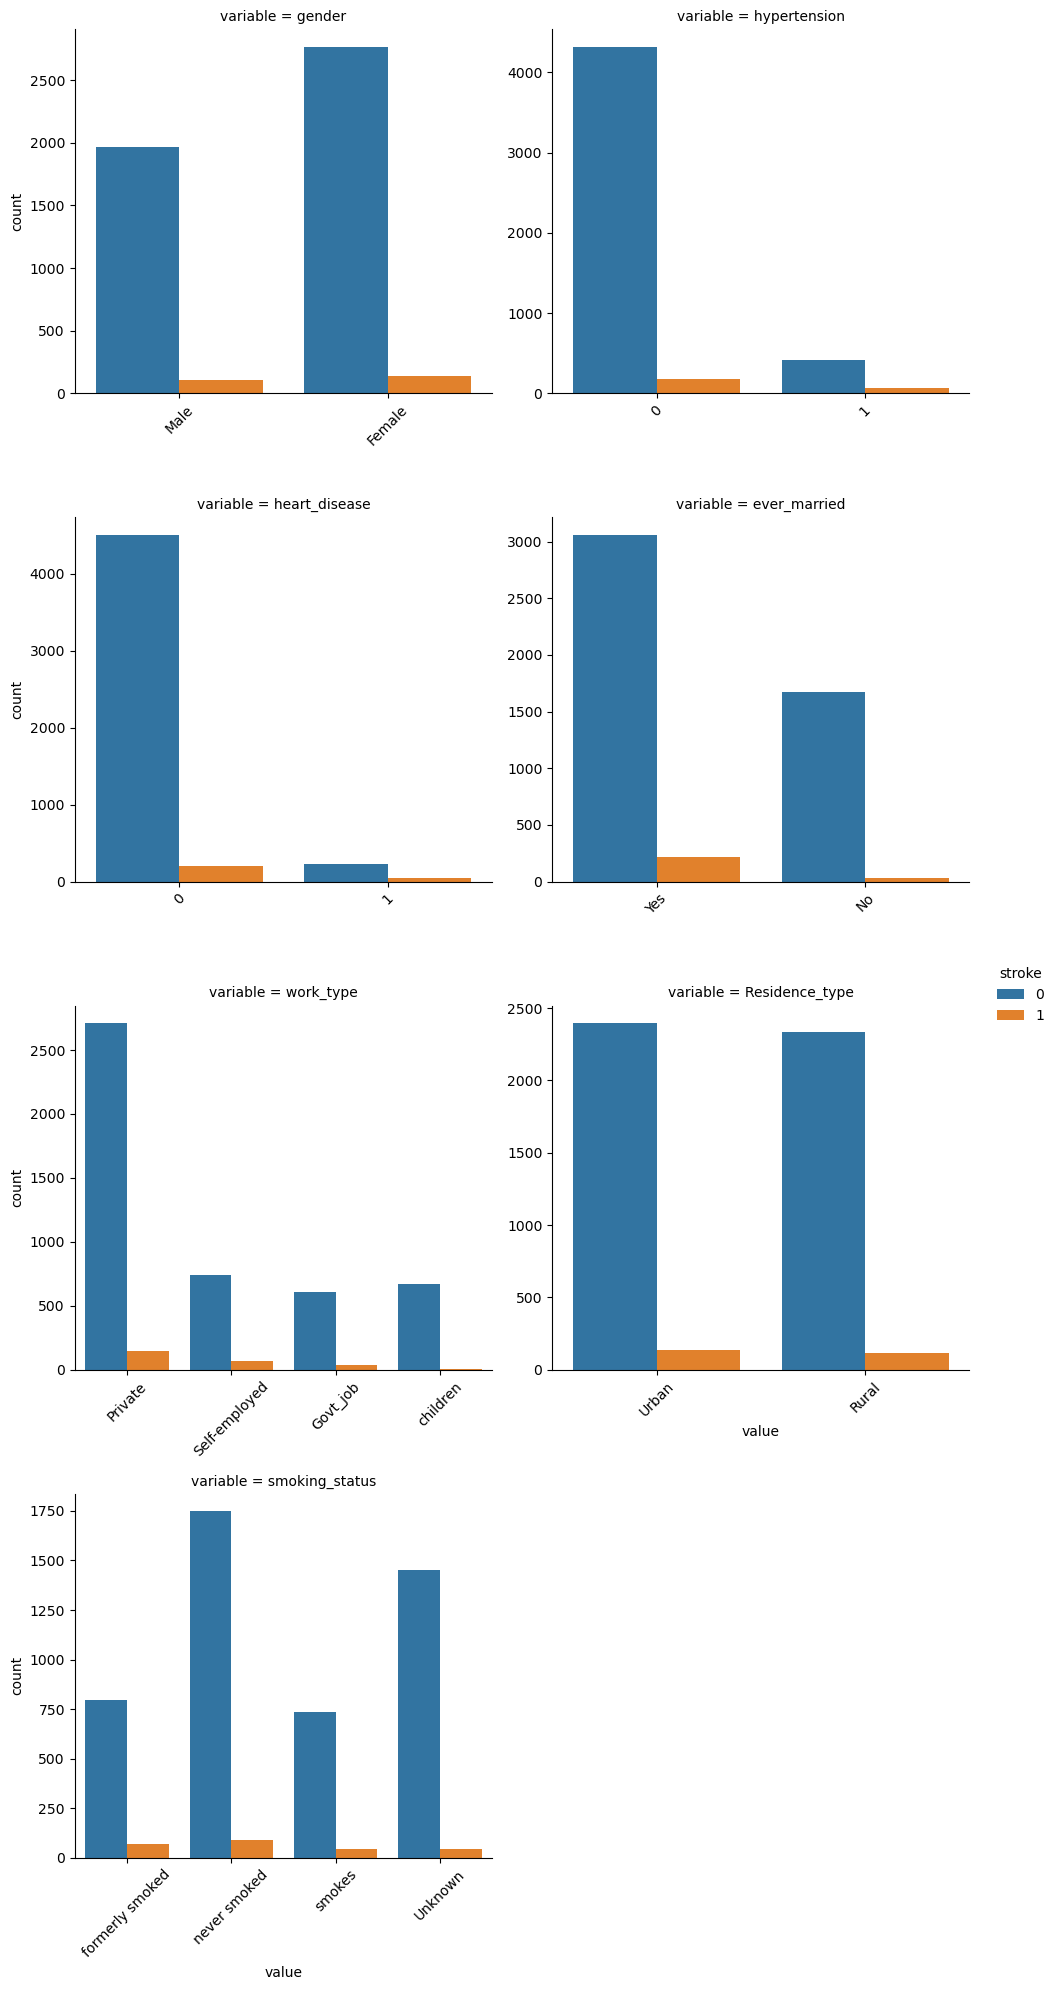

In [6]:
g=sns.catplot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

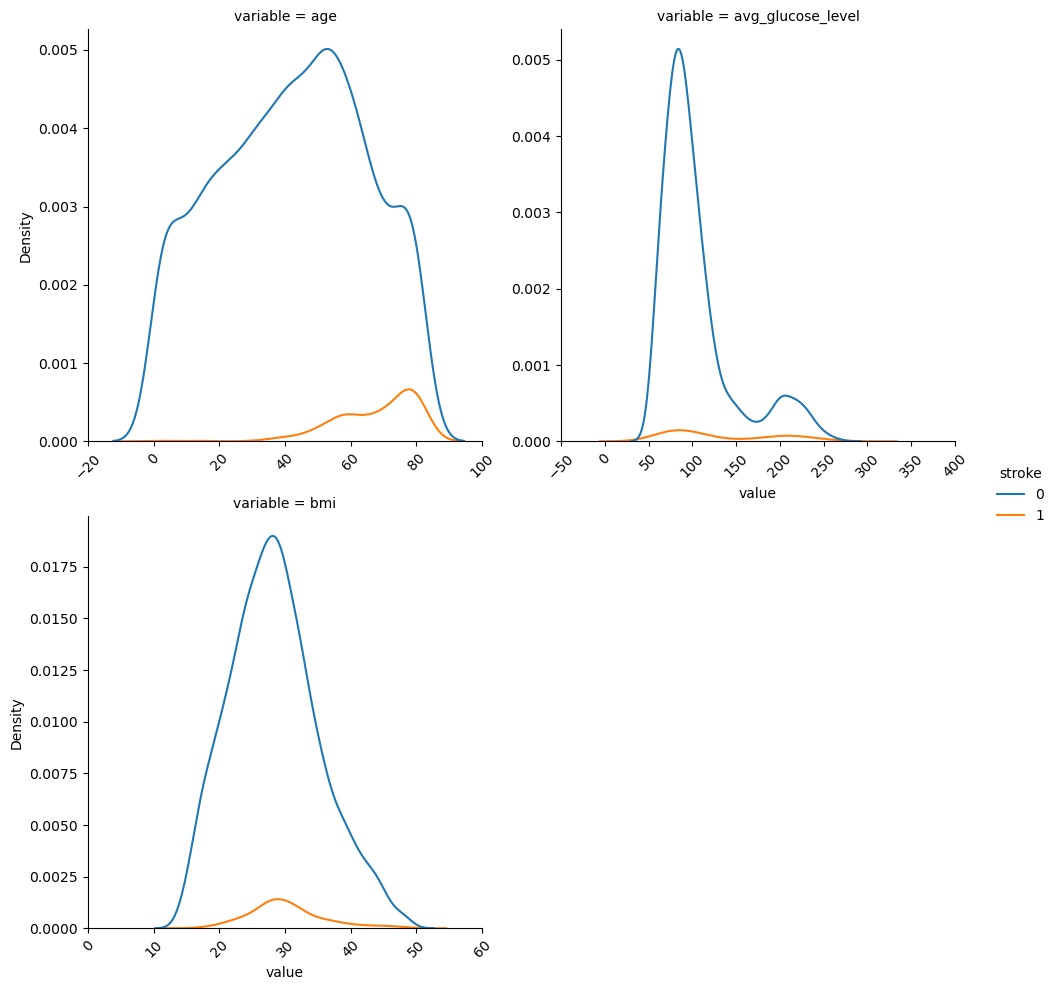

In [7]:
g=sns.displot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='kde',
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
)
g.set_xticklabels(rotation=45)
g.tight_layout();

<AxesSubplot:xlabel='age', ylabel='Density'>

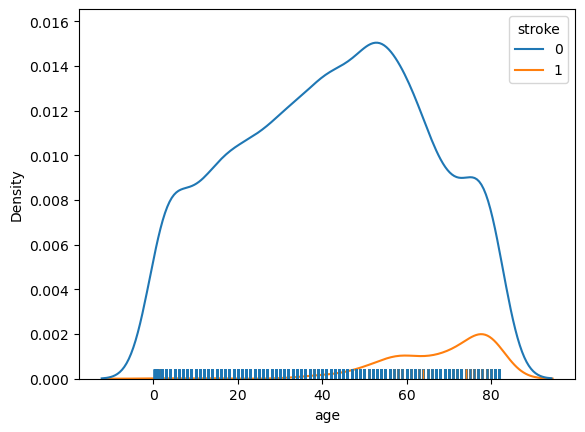

In [12]:
sns.kdeplot(
    x='age',
    data=stroke,
    hue='stroke',
)
sns.rugplot(
    x='age',
    data=stroke,
    hue='stroke',
)

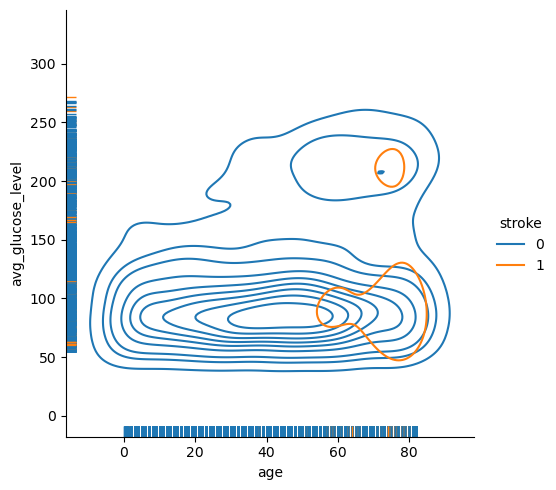

In [16]:
sns.displot(
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    data=stroke,
    kind='kde',
    rug=True
);

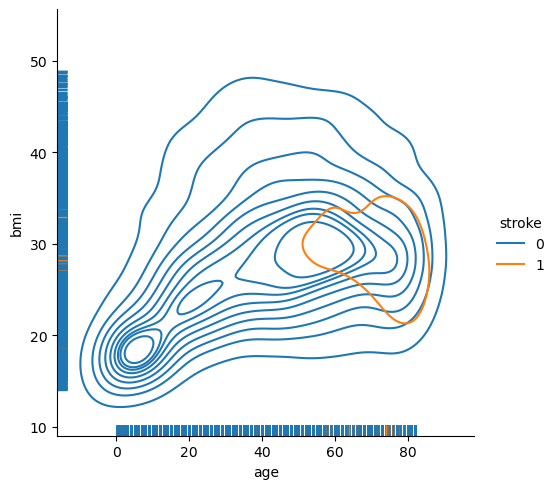

In [17]:
sns.displot(
    x='age',
    y='bmi',
    hue='stroke',
    data=stroke,
    kind='kde',
    rug=True
);

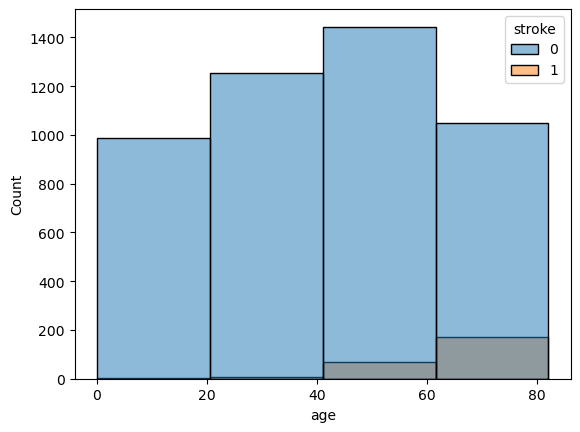

In [54]:
sns.histplot(
    x='age',
    data=stroke,
    hue='stroke',
    bins=4
);

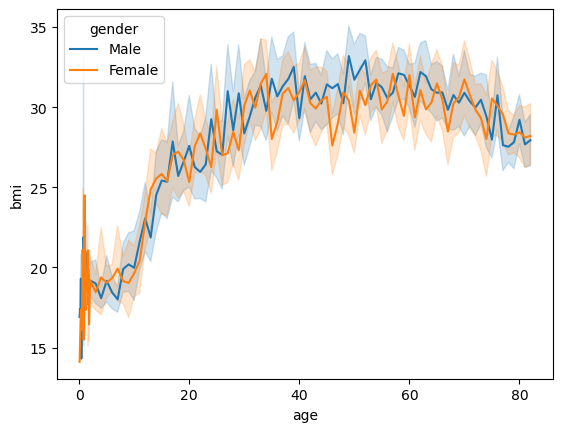

In [53]:
sns.lineplot(
    x='age',
    y='bmi',
    hue='gender',
    data=stroke,
);

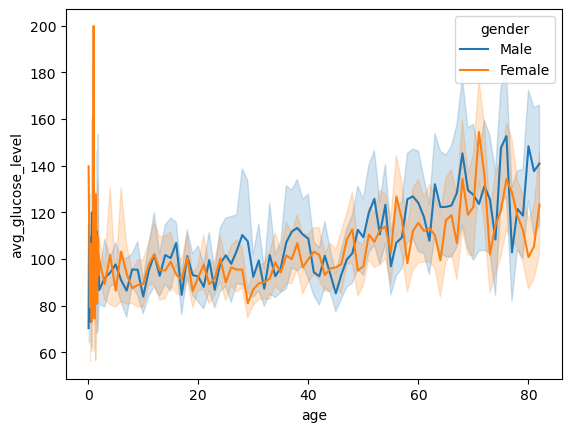

In [54]:
sns.lineplot(
    x='age',
    y='avg_glucose_level',
    hue='gender',
    data=stroke,
);

C:\Users\dimin\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


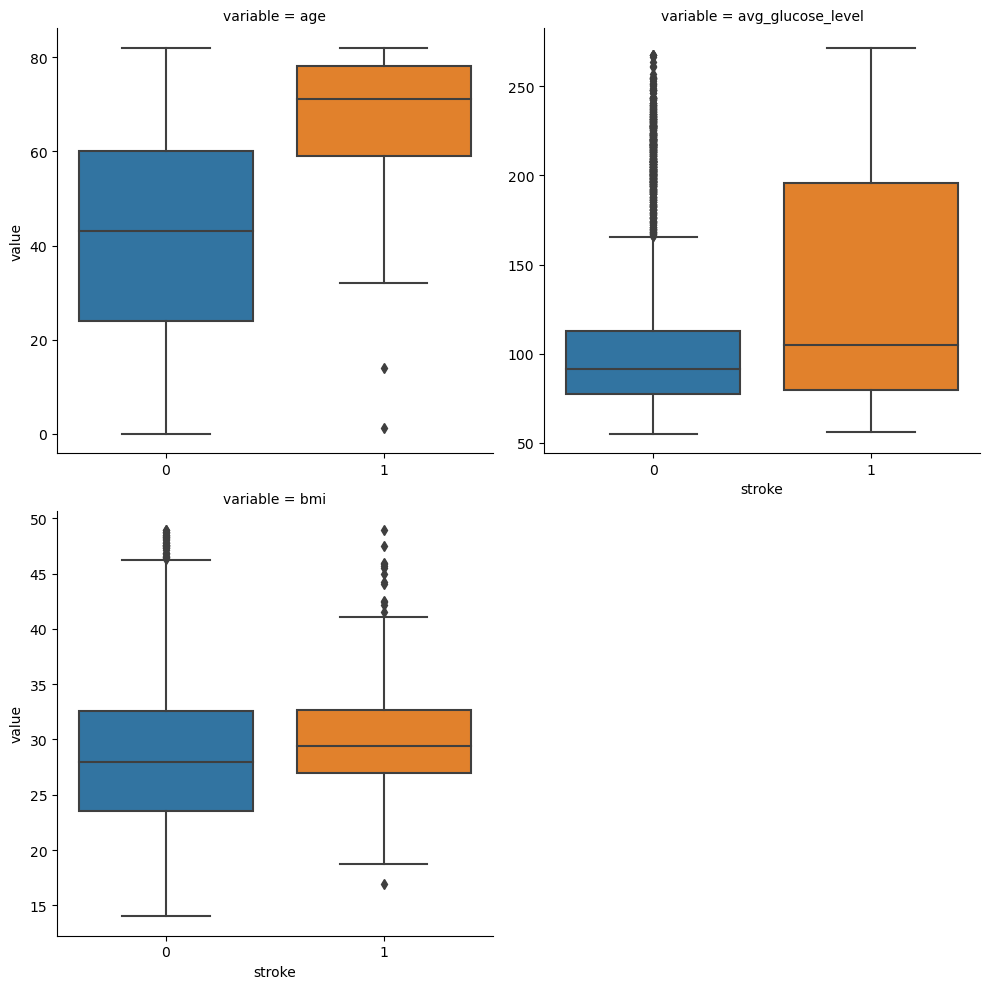

In [75]:
g=sns.catplot(
    y='value',
    x='stroke',
#    hue='gender',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='box',
    col_wrap=2,
    sharex=False, 
    sharey=False,
)

## 3. Data Preparation

### 3.1 Base test

In [3]:
stroke_train, stroke_test = train_test_split(stroke, test_size=0.2, random_state=42)

In [4]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [5]:
y_train.value_counts()

0    3790
1     194
Name: stroke, dtype: int64

In [6]:
cat_columns = X_train.select_dtypes(object).columns

In [7]:
num_columns = X_train.select_dtypes(exclude=object).columns

In [8]:
def make_scores(y_train, y_pred):
    print(
        'accuracy_score =', accuracy_score(y_train, y_pred),'\n'
        'precision_score =', precision_score(y_train, y_pred),'\n'
        'recall_score =', recall_score(y_train, y_pred),'\n'
        'f1_score =', f1_score(y_train, y_pred),
    )

In [9]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [10]:
X_train_encoded = prep.fit_transform(X_train)

In [11]:
sgd_clf = SGDClassifier(random_state=42)
log_clf = LogisticRegression(random_state=42)
svc_clf = LinearSVC(random_state=42)
svm_clf = SVC(random_state=42)
tre_clf = DecisionTreeClassifier(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
ext_clf = ExtraTreeClassifier(random_state=42)

In [12]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ext_clf,
    ):
    clf.fit(X_train_encoded, y_train)
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=3, method="predict")
    print(clf.__class__.__name__)
    make_scores(y_train, y_train_pred)
    print('*'*10)

SGDClassifier
accuracy_score = 0.9482931726907631 
precision_score = 0.22727272727272727 
recall_score = 0.02577319587628866 
f1_score = 0.046296296296296294
**********
LogisticRegression
accuracy_score = 0.9515562248995983 
precision_score = 1.0 
recall_score = 0.005154639175257732 
f1_score = 0.010256410256410256
**********
LinearSVC
accuracy_score = 0.9513052208835341 
precision_score = 0.0 
recall_score = 0.0 
f1_score = 0.0
**********
SVC
accuracy_score = 0.9513052208835341 
precision_score = 0.0 
recall_score = 0.0 
f1_score = 0.0
**********
DecisionTreeClassifier
accuracy_score = 0.911144578313253 
precision_score = 0.1875 
recall_score = 0.24742268041237114 
f1_score = 0.21333333333333335
**********
RandomForestClassifier
accuracy_score = 0.9510542168674698 
precision_score = 0.3333333333333333 
recall_score = 0.005154639175257732 
f1_score = 0.010152284263959392
**********
ExtraTreeClassifier
accuracy_score = 0.9139056224899599 
precision_score = 0.11794871794871795 
recall_sc

**Используем балансировку**

In [13]:
sgd_clf = SGDClassifier(random_state=42, class_weight='balanced')
log_clf = LogisticRegression(random_state=42, class_weight='balanced')
svc_clf = LinearSVC(random_state=42, class_weight='balanced')
svm_clf = SVC(random_state=42, class_weight='balanced')
tre_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rnd_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
ext_clf = ExtraTreeClassifier(random_state=42, class_weight='balanced')

In [14]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ext_clf,
    ):
    clf.fit(X_train_encoded, y_train)
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=3, method="predict")
    print(clf.__class__.__name__)
    make_scores(y_train, y_train_pred)
    print('*'*10)

SGDClassifier
accuracy_score = 0.6691767068273092 
precision_score = 0.09971509971509972 
recall_score = 0.7216494845360825 
f1_score = 0.17521902377972468
**********
LogisticRegression
accuracy_score = 0.733433734939759 
precision_score = 0.13406408094435077 
recall_score = 0.8195876288659794 
f1_score = 0.23043478260869568
**********
LinearSVC
accuracy_score = 0.7271586345381527 
precision_score = 0.1325102880658436 
recall_score = 0.8298969072164949 
f1_score = 0.22853087295954577
**********
SVC
accuracy_score = 0.7758534136546185 
precision_score = 0.12700106723585913 
recall_score = 0.6134020618556701 
f1_score = 0.21043324491600354
**********
DecisionTreeClassifier
accuracy_score = 0.9146586345381527 
precision_score = 0.135 
recall_score = 0.13917525773195877 
f1_score = 0.13705583756345177
**********
RandomForestClassifier
accuracy_score = 0.9503012048192772 
precision_score = 0.0 
recall_score = 0.0 
f1_score = 0.0
**********
ExtraTreeClassifier
accuracy_score = 0.915160642570

можно не запускать
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf, 
    tre_clf, 
    rnd_clf,
    ext_clf,
    ):
    clf.fit(X_train_encoded, y_train)
    print(clf.__class__.__name__)
    score = cross_val_score(clf, X_train_encoded, y_train, cv=3, scoring="f1")
    print(score.mean())
    print('*'*10)

### 3.2 Feature engineering

In [15]:
stroke['ever_married'] = stroke.ever_married.map(lambda x: 1 if x=='Yes' else 0)

In [16]:
stroke['gender'] = stroke.gender.map(lambda x: 1 if x=='Male' else 0)

In [17]:
stroke['Residence_type'] = stroke.Residence_type.map(lambda x: 1 if x=='Urban' else 0)

In [18]:
stroke['age_category'] = stroke.age.map(
    lambda x: 'kind' if x<18 
    else ('young' if 18<=x<40 
          else ('medium' if 40<=x<60 else 'old')
         ))

In [19]:
stroke.groupby('age_category').stroke.mean()

age_category
kind      0.002430
medium    0.039099
old       0.132504
young     0.004677
Name: stroke, dtype: float64

In [20]:
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1,old
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1,old
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1,medium
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1,old
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1,old


In [21]:
stroke['diabeth'] = stroke.avg_glucose_level.map(lambda x: 1 if x>150 else 0)

In [22]:
stroke.groupby('diabeth').stroke.mean()

diabeth
0    0.037158
1    0.126781
Name: stroke, dtype: float64

In [23]:
stroke['diseases'] = stroke.apply(lambda x: x.diabeth+x.hypertension+x.heart_disease, axis=1)

In [24]:
stroke.groupby('diseases').stroke.mean()

diseases
0    0.027967
1    0.099323
2    0.189873
3    0.250000
Name: stroke, dtype: float64

In [25]:
stroke.groupby(['age_category', 'diseases']).stroke.mean()

age_category  diseases
kind          0           0.002528
              1           0.000000
medium        0           0.029514
              1           0.055172
              2           0.126984
              3           0.250000
old           0           0.092179
              1           0.157428
              2           0.216374
              3           0.250000
young         0           0.004284
              1           0.008850
              2           0.000000
Name: stroke, dtype: float64

In [26]:
stroke['index_risk'] = stroke.apply(lambda x: x.age*x.diseases, axis=1)

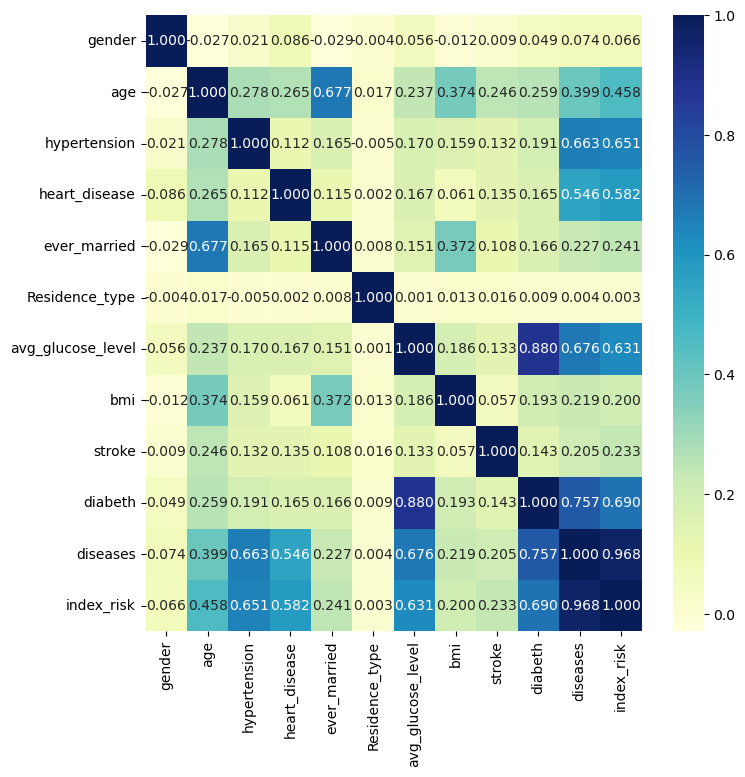

In [27]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    stroke.corr(), 
    annot=True, 
    cmap='YlGnBu',
    fmt='.3f',
);

In [28]:
((stroke.corr() > 0.8) & (stroke.corr() != 1)).any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
Residence_type       False
avg_glucose_level     True
bmi                  False
stroke               False
diabeth               True
diseases              True
index_risk            True
dtype: bool

Видим, что **index_risk** и **diseases** имеют сильную корреляцию. В свою очередь, **index_risk** имеет большую корреляцию с **stroke**. Поэтому удаляем **diseases**. Такая же ситуация с **avg_glucose_level** и **diabeth**. Можно удалить **avg_glucose_level**.

In [29]:
stroke.corr()['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.246478
index_risk           0.232598
diseases             0.204830
diabeth              0.143371
heart_disease        0.134610
avg_glucose_level    0.133227
hypertension         0.131965
ever_married         0.108398
bmi                  0.056926
Residence_type       0.016494
gender               0.008870
Name: stroke, dtype: float64

## 4. Modeling

In [30]:
stroke_train, stroke_test = train_test_split(stroke, test_size=0.2, random_state=42)

In [31]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [32]:
cat_columns = X_train.select_dtypes(object).columns

In [33]:
num_columns = X_train.select_dtypes(exclude=object).columns

In [34]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [35]:
X_train_encoded = prep.fit_transform(X_train)

In [36]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ext_clf,
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=3, method="predict")
    print(clf.__class__.__name__)
    make_scores(y_train, y_train_pred)
    print('*'*10)

SGDClassifier
accuracy_score = 0.8007028112449799 
precision_score = 0.12871287128712872 
recall_score = 0.5360824742268041 
f1_score = 0.20758483033932135
**********
LogisticRegression
accuracy_score = 0.7366967871485943 
precision_score = 0.1343028229255774 
recall_score = 0.8092783505154639 
f1_score = 0.23037417461482027
**********
LinearSVC
accuracy_score = 0.7359437751004017 
precision_score = 0.13458262350936967 
recall_score = 0.8144329896907216 
f1_score = 0.2309941520467836
**********
SVC
accuracy_score = 0.7808734939759037 
precision_score = 0.12235817575083426 
recall_score = 0.5670103092783505 
f1_score = 0.2012808783165599
**********
DecisionTreeClassifier
accuracy_score = 0.911144578313253 
precision_score = 0.11538461538461539 
recall_score = 0.12371134020618557 
f1_score = 0.11940298507462688
**********
RandomForestClassifier
accuracy_score = 0.9505522088353414 
precision_score = 0.3333333333333333 
recall_score = 0.015463917525773196 
f1_score = 0.02955665024630542
**

## 5. Tuning models

### SGDClassifier

In [590]:
sgd_clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [591]:
param_grid = {
    'penalty' : ['l1','l2'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'early_stopping': [False, True],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.1],
    'loss': ['hinge', 'huber']
}

sgd_clf_search = GridSearchCV(estimator=sgd_clf, param_grid=param_grid, cv=3, scoring='accuracy')
sgd_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', random_state=42),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'early_stopping': [False, True], 'eta0': [0.1],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['hinge', 'huber'], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [592]:
best_params = sgd_clf_search.best_params_
best_params

{'alpha': 0.1,
 'early_stopping': False,
 'eta0': 0.1,
 'learning_rate': 'constant',
 'loss': 'huber',
 'penalty': 'l2'}

In [593]:
sgd_clf_search.best_score_

0.8245481927710844

In [594]:
sgd_clf_best = sgd_clf_search.best_estimator_

In [595]:
y_pred = sgd_clf_best.predict(X_train_encoded)

In [596]:
confusion_matrix(y_train, y_pred)

array([[2668, 1122],
       [  37,  157]], dtype=int64)

In [597]:
make_scores(y_train, y_pred)

accuracy_score = 0.7090863453815262 
precision_score = 0.12275215011727912 
recall_score = 0.8092783505154639 
f1_score = 0.2131704005431093


### Logistic Regression

In [553]:
log_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [554]:
param_grid = {
    'penalty' : ['l1','l2', 'none'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

log_clf_search = GridSearchCV(estimator=log_clf, param_grid=param_grid, cv=3, scoring='f1')
log_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [555]:
best_params = log_clf_search.best_params_
best_params

{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

In [556]:
log_clf_search.best_score_

0.23194003453548506

In [557]:
log_clf_best = log_clf_search.best_estimator_

In [558]:
y_pred = log_clf_best.predict(X_train_encoded)

In [559]:
confusion_matrix(y_train, y_pred)

array([[2749, 1041],
       [  31,  163]], dtype=int64)

In [560]:
make_scores(y_train, y_pred)

accuracy_score = 0.7309236947791165 
precision_score = 0.13538205980066445 
recall_score = 0.8402061855670103 
f1_score = 0.23319027181688126


### LinearSVC

In [114]:
svc_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [162]:
param_grid = {
    'penalty' : ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
}

svc_clf_search = GridSearchCV(estimator=svc_clf, param_grid=param_grid, cv=3, scoring='f1')
svc_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3,
             estimator=LinearSVC(class_weight='balanced', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [163]:
best_params = svc_clf_search.best_params_
best_params

{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}

In [164]:
svc_clf_search.best_score_

0.23447674211906655

In [165]:
svc_clf_best = svc_clf_search.best_estimator_

In [166]:
y_pred = svc_clf_best.predict(X_train_encoded)

In [167]:
confusion_matrix(y_train, y_pred)

array([[2754, 1036],
       [  30,  164]], dtype=int64)

In [168]:
make_scores(y_train, y_pred)

accuracy_score = 0.732429718875502 
precision_score = 0.13666666666666666 
recall_score = 0.845360824742268 
f1_score = 0.23529411764705885


### SVC

In [573]:
svm_clf = SVC(random_state=42, class_weight='balanced')

In [574]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [186]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.01, 1, 100],
        'gamma': [0.1, 1, 10]
    },
    {
        'kernel': ['poly'],
        'coef0': [0, 1, 5, 10],
        'C': [0.01, 1, 100],
        'gamma': [0.1, 1, 10]
    }
]

svm_clf_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=3, scoring='f1')
svm_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', random_state=42),
             param_grid=[{'C': [0.01, 1, 100], 'gamma': [0.1, 1, 10],
                          'kernel': ['rbf']},
                         {'C': [0.01, 1, 100], 'coef0': [0, 1, 5, 10],
                          'gamma': [0.1, 1, 10], 'kernel': ['poly']}],
             scoring='accuracy')

In [417]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': np.linspace(0.0001, 0.01, 100),
        'gamma': np.linspace(0.0001, 0.01, 100)
    },
]

svm_clf_search = RandomizedSearchCV(estimator=svm_clf, param_distributions=param_grid, n_iter=10, cv=3, scoring='f1')
svm_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=3,
                   estimator=SVC(class_weight='balanced', random_state=42),
                   param_distributions=[{'C': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0...
       0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056,
       0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063, 0.0064,
       0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071, 0.0072,
       0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008 ,
       0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088,
       0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096,
       0.0097, 0.0098, 0.0099, 0.01  ]),
                                         'kernel': ['rbf']}],
                   scoring='f1')

In [418]:
cvres = svm_clf_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.22024089041123143 {'kernel': 'rbf', 'gamma': 0.0086, 'C': 0.0074}
0.09286718210648205 {'kernel': 'rbf', 'gamma': 0.005, 'C': 0.0013000000000000002}
0.06221584111031347 {'kernel': 'rbf', 'gamma': 0.0024, 'C': 0.0033}
0.23110193113195818 {'kernel': 'rbf', 'gamma': 0.0079, 'C': 0.006500000000000001}
0.21730617721562662 {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.0085}
0.06221584111031347 {'kernel': 'rbf', 'gamma': 0.00030000000000000003, 'C': 0.0071}
0.12958520352886552 {'kernel': 'rbf', 'gamma': 0.0035, 'C': 0.0067}
0.0 {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.0039}
0.0 {'kernel': 'rbf', 'gamma': 0.0087, 'C': 0.0019000000000000002}
0.07885304659498209 {'kernel': 'rbf', 'gamma': 0.0013000000000000002, 'C': 0.0047}


In [419]:
best_params = svm_clf_search.best_params_
best_params

{'kernel': 'rbf', 'gamma': 0.0079, 'C': 0.006500000000000001}

In [575]:
filename = 'svm_model.pickle'

In [694]:
# Запись модели
with open(filename, 'wb') as file:
    pickle.dump(svm_clf_best, file)

In [576]:
# Загрузка модели
with open(filename, 'rb') as file:
    svm_clf_best = pickle.load(file)

In [699]:
svm_clf_search.best_score_

0.23110193113195818

In [697]:
svm_clf_best = svm_clf_search.best_estimator_

In [757]:
y_pred = svm_clf_best.predict(X_train_encoded)

In [758]:
confusion_matrix(y_train, y_pred)

array([[3512,  278],
       [ 134,   60]], dtype=int64)

In [702]:
make_scores(y_train, y_pred)

accuracy_score = 0.8965863453815262 
precision_score = 0.17751479289940827 
recall_score = 0.30927835051546393 
f1_score = 0.22556390977443608


Модель явно переобучена! Требуется регуляризация путём уменьшения параметров гамма и С

### DecisionTreeClassifier

In [194]:
tre_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [195]:
param_grid = {
    'max_depth': np.arange(2, 4, 1),
    'max_features': np.arange(2, 5, 1),
    'max_leaf_nodes': np.arange(2, 4, 1),
    'min_samples_leaf': np.arange(1, 3, 1),
    'min_samples_split': np.arange(2, 4, 1),
}

tre_clf_search = GridSearchCV(estimator=tre_clf, param_grid=param_grid, cv=3, scoring='accuracy')
tre_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': array([2, 3]),
                         'max_features': array([2, 3, 4]),
                         'max_leaf_nodes': array([2, 3]),
                         'min_samples_leaf': array([1, 2]),
                         'min_samples_split': array([2, 3])},
             scoring='accuracy')

In [196]:
best_params = tre_clf_search.best_params_
best_params

{'max_depth': 2,
 'max_features': 4,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [197]:
tre_clf_search.best_score_

0.8340863453815262

In [198]:
tre_clf_best = tre_clf_search.best_estimator_

In [199]:
y_pred = tre_clf_best.predict(X_train_encoded)

In [200]:
confusion_matrix(y_train, y_pred)

array([[3155,  635],
       [  86,  108]], dtype=int64)

In [201]:
make_scores(y_train, y_pred)

accuracy_score = 0.8190261044176707 
precision_score = 0.14535666218034993 
recall_score = 0.5567010309278351 
f1_score = 0.2305229455709712


In [450]:
sorted(zip(prep.get_feature_names_out(), tre_clf_best.feature_importances_), reverse=True)

[('num__index_risk', 1.0),
 ('num__hypertension', 0.0),
 ('num__heart_disease', 0.0),
 ('num__gender', 0.0),
 ('num__ever_married', 0.0),
 ('num__diseases', 0.0),
 ('num__diabeth', 0.0),
 ('num__bmi', 0.0),
 ('num__avg_glucose_level', 0.0),
 ('num__age', 0.0),
 ('num__Residence_type', 0.0),
 ('cat__work_type_children', 0.0),
 ('cat__work_type_Self-employed', 0.0),
 ('cat__work_type_Private', 0.0),
 ('cat__work_type_Govt_job', 0.0),
 ('cat__smoking_status_smokes', 0.0),
 ('cat__smoking_status_never smoked', 0.0),
 ('cat__smoking_status_formerly smoked', 0.0),
 ('cat__smoking_status_Unknown', 0.0),
 ('cat__age_category_young', 0.0),
 ('cat__age_category_old', 0.0),
 ('cat__age_category_medium', 0.0),
 ('cat__age_category_kind', 0.0)]

### RandomForestClassifier

In [460]:
rnd_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [498]:
param_grid = {
    'bootstrap': [True],
    'oob_score': [True],
    'max_depth': np.arange(2, 100),
    'max_features': np.arange(2, 20),
    'max_leaf_nodes': np.arange(2, 100),
    'min_samples_leaf': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'n_estimators': [100, 200, 500, 1000],
}

rnd_clf_search = RandomizedSearchCV(estimator=rnd_clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1')
rnd_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, ...],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 500, 1000],
                                        'oob_score': [True]},
                   scoring='f1')

In [499]:
best_params = rnd_clf_search.best_params_
best_params

{'oob_score': True,
 'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 21,
 'max_features': 9,
 'max_depth': 93,
 'bootstrap': True}

In [500]:
rnd_clf_best.oob_score_

0.7818775100401606

In [501]:
rnd_clf_search.best_score_

0.2567358899633336

In [502]:
rnd_clf_best = rnd_clf_search.best_estimator_

In [588]:
filename = 'rnd_model.pickle'

In [486]:
# Запись модели
with open(filename, 'wb') as file:
    pickle.dump(rnd_clf_best, file)

In [589]:
# Загрузка модели
with open(filename, 'rb') as file:
    rnd_clf_best = pickle.load(file)

In [204]:
y_pred = rnd_clf_best.predict(X_train_encoded)

In [205]:
confusion_matrix(y_train, y_pred)

array([[3229,  561],
       [  20,  174]], dtype=int64)

In [206]:
make_scores(y_train, y_pred)

accuracy_score = 0.8541666666666666 
precision_score = 0.23673469387755103 
recall_score = 0.8969072164948454 
f1_score = 0.37459634015069965


In [474]:
sorted(zip(rnd_clf_best.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.37979875851930883, 'num__age'),
 (0.13676066420646843, 'num__bmi'),
 (0.13031531093433815, 'num__avg_glucose_level'),
 (0.09788661988621211, 'cat__age_category_old'),
 (0.07530341096017523, 'num__index_risk'),
 (0.01990831160151647, 'num__diseases'),
 (0.016658538061970474, 'cat__smoking_status_never smoked'),
 (0.014297894059479453, 'num__gender'),
 (0.01416096184796847, 'num__ever_married'),
 (0.012503085091732948, 'cat__age_category_young'),
 (0.012129508959680957, 'cat__age_category_medium'),
 (0.012056918124620414, 'cat__smoking_status_smokes'),
 (0.011908355826171479, 'num__Residence_type'),
 (0.011240639730079596, 'cat__work_type_Self-employed'),
 (0.008897138631212761, 'cat__work_type_Private'),
 (0.008534678897228618, 'cat__smoking_status_formerly smoked'),
 (0.008343397758658928, 'cat__work_type_Govt_job'),
 (0.007952764382920433, 'cat__smoking_status_Unknown'),
 (0.0074747378809249575, 'num__hypertension'),
 (0.004577926269232644, 'num__diabeth'),
 (0.0037471460705625925

### ExtraTreeClassifier

In [514]:
ext_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'random'}

In [668]:
param_grid = {
    'max_depth': np.arange(2, 100),
    'max_features': np.arange(2, 20),
    'max_leaf_nodes': np.arange(2, 100),
    'min_samples_leaf': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
}

ext_clf_search = RandomizedSearchCV(estimator=ext_clf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
ext_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=3,
                   estimator=ExtraTreeClassifier(class_weight='balanced',
                                                 random_state=42),
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 7...
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='accuracy')

In [669]:
best_params = ext_clf_search.best_params_
best_params

{'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 89,
 'max_features': 17,
 'max_depth': 70}

In [670]:
ext_clf_search.best_score_

0.7863955823293173

In [671]:
ext_clf_best = ext_clf_search.best_estimator_

In [270]:
filename = 'ext_model.pickle'

In [675]:
# Запись модели
with open(filename, 'wb') as file:
    pickle.dump(ext_clf_best, file)

In [271]:
# Загрузка модели
with open(filename, 'rb') as file:
    ext_clf_best = pickle.load(file)

In [209]:
y_pred = ext_clf_best.predict(X_train_encoded)

In [210]:
confusion_matrix(y_train, y_pred)

array([[3115,  675],
       [  15,  179]], dtype=int64)

In [211]:
make_scores(y_train, y_pred)

accuracy_score = 0.8268072289156626 
precision_score = 0.20960187353629978 
recall_score = 0.9226804123711341 
f1_score = 0.34160305343511455


In [97]:
sorted(zip(ext_clf_best.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.58209020481704, 'num__age'),
 (0.052400048624313945, 'num__avg_glucose_level'),
 (0.04660986282412213, 'num__gender'),
 (0.041860143691706306, 'num__bmi'),
 (0.03608296554575591, 'cat__smoking_status_Unknown'),
 (0.03161942063248784, 'num__diabeth'),
 (0.03151423875038952, 'cat__smoking_status_never smoked'),
 (0.029645946449376848, 'num__ever_married'),
 (0.02605776479477795, 'num__Residence_type'),
 (0.0212429551427498, 'cat__work_type_Govt_job'),
 (0.01970939054287713, 'cat__smoking_status_smokes'),
 (0.01629790291740889, 'num__hypertension'),
 (0.016123631854673047, 'cat__work_type_Private'),
 (0.014400159519769806, 'cat__smoking_status_formerly smoked'),
 (0.009805683508713529, 'cat__work_type_Self-employed'),
 (0.009127114297357047, 'cat__age_category_young'),
 (0.007115339618066029, 'num__index_risk'),
 (0.0063969880316065994, 'num__diseases'),
 (0.0019002384368075724, 'cat__age_category_old'),
 (0.0, 'num__heart_disease'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__age

### VotingClassifier

In [741]:
# voting = 'hard'
vot_clf = VotingClassifier(
    estimators=[
        ('log', log_clf_best),
        ('svm', svm_clf_best),
        ('tre', tre_clf_best),
        ('rnd', rnd_clf_best),
    ],
)

In [742]:
vot_clf.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 random_state=42,
                                                 solver='sag')),
                             ('svm',
                              SVC(C=0.04, class_weight='balanced', coef0=1,
                                  gamma=0.0005, probability=True,
                                  random_state=42)),
                             ('tre',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features=4,
                                                     max_leaf_nodes=2,
                                                     random_state=42)),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=71,
                                                     max_features=16,
                                                     max_leaf_nodes=35,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     random_state=42))])

In [743]:
for clf in (
    log_clf_best,
    svm_clf_best,
    tre_clf_best, 
    rnd_clf_best,
    vot_clf,
    ):
    y_pred = clf.predict(X_train_encoded)
    print(clf.__class__.__name__)
    make_scores(y_train, y_pred)
    print('*'*10)

LogisticRegression
accuracy_score = 0.7309236947791165 
precision_score = 0.13538205980066445 
recall_score = 0.8402061855670103 
f1_score = 0.23319027181688126
**********
SVC
accuracy_score = 0.8965863453815262 
precision_score = 0.17751479289940827 
recall_score = 0.30927835051546393 
f1_score = 0.22556390977443608
**********
DecisionTreeClassifier
accuracy_score = 0.8190261044176707 
precision_score = 0.14535666218034993 
recall_score = 0.5567010309278351 
f1_score = 0.2305229455709712
**********
RandomForestClassifier
accuracy_score = 0.8541666666666666 
precision_score = 0.23673469387755103 
recall_score = 0.8969072164948454 
f1_score = 0.37459634015069965
**********
VotingClassifier
accuracy_score = 0.8790160642570282 
precision_score = 0.2073170731707317 
recall_score = 0.5257731958762887 
f1_score = 0.29737609329446063
**********


In [744]:
confusion_matrix(y_train, y_pred)

array([[3400,  390],
       [  92,  102]], dtype=int64)

In [745]:
# voting = 'soft'
vot_clf = VotingClassifier(
    estimators=[
        ('log', log_clf_best),
        ('svm', svm_clf_best),
        ('tre', tre_clf_best),
        ('rnd', rnd_clf_best),
    ],
)
vot_clf.voting = 'soft'
svm_clf_best.probability = True

In [746]:
vot_clf.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 random_state=42,
                                                 solver='sag')),
                             ('svm',
                              SVC(C=0.04, class_weight='balanced', coef0=1,
                                  gamma=0.0005, probability=True,
                                  random_state=42)),
                             ('tre',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features=4,
                                                     max_leaf_nodes=2,
                                                     random_state=42)),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=71,
                                                     max_features=16,
                                                     max_leaf_nodes=35,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')

In [747]:
for clf in (
    log_clf_best,
    svm_clf_best,
    tre_clf_best, 
    rnd_clf_best,
    vot_clf,
    ):
    y_pred = clf.predict(X_train_encoded)
    print(clf.__class__.__name__)
    make_scores(y_train, y_pred)
    print('*'*10)

LogisticRegression
accuracy_score = 0.7309236947791165 
precision_score = 0.13538205980066445 
recall_score = 0.8402061855670103 
f1_score = 0.23319027181688126
**********
SVC
accuracy_score = 0.8965863453815262 
precision_score = 0.17751479289940827 
recall_score = 0.30927835051546393 
f1_score = 0.22556390977443608
**********
DecisionTreeClassifier
accuracy_score = 0.8190261044176707 
precision_score = 0.14535666218034993 
recall_score = 0.5567010309278351 
f1_score = 0.2305229455709712
**********
RandomForestClassifier
accuracy_score = 0.8541666666666666 
precision_score = 0.23673469387755103 
recall_score = 0.8969072164948454 
f1_score = 0.37459634015069965
**********
VotingClassifier
accuracy_score = 0.8878012048192772 
precision_score = 0.22319474835886213 
recall_score = 0.5257731958762887 
f1_score = 0.3133640552995392
**********


In [748]:
confusion_matrix(y_train, y_pred)

array([[3435,  355],
       [  92,  102]], dtype=int64)

Удалим **LogisticRegression**

In [731]:
vot_clf = vot_clf.set_params(log='drop')

In [732]:
vot_clf.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('log', 'drop'),
                             ('svm',
                              SVC(C=0.04, class_weight='balanced', coef0=1,
                                  gamma=0.0005, probability=True,
                                  random_state=42)),
                             ('tre',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features=4,
                                                     max_leaf_nodes=2,
                                                     random_state=42)),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=71,
                                                     max_features=16,
                                                     max_leaf_nodes=35,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')

In [735]:
for clf in (
    svm_clf_best,
    tre_clf_best, 
    rnd_clf_best,
    vot_clf,
    ):
    y_pred = clf.predict(X_train_encoded)
    print(clf.__class__.__name__)
    make_scores(y_train, y_pred)
    print('*'*10)

SVC
accuracy_score = 0.8965863453815262 
precision_score = 0.17751479289940827 
recall_score = 0.30927835051546393 
f1_score = 0.22556390977443608
**********
DecisionTreeClassifier
accuracy_score = 0.8190261044176707 
precision_score = 0.14535666218034993 
recall_score = 0.5567010309278351 
f1_score = 0.2305229455709712
**********
RandomForestClassifier
accuracy_score = 0.8541666666666666 
precision_score = 0.23673469387755103 
recall_score = 0.8969072164948454 
f1_score = 0.37459634015069965
**********
VotingClassifier
accuracy_score = 0.918925702811245 
precision_score = 0.2899022801302932 
recall_score = 0.4587628865979381 
f1_score = 0.35528942115768464
**********


In [736]:
confusion_matrix(y_train, y_pred)

array([[3572,  218],
       [ 105,   89]], dtype=int64)

Удалим **DecisionTreeClassifier**

In [737]:
vot_clf = vot_clf.set_params(tre='drop')

In [738]:
vot_clf.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('log', 'drop'),
                             ('svm',
                              SVC(C=0.04, class_weight='balanced', coef0=1,
                                  gamma=0.0005, probability=True,
                                  random_state=42)),
                             ('tre', 'drop'),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=71,
                                                     max_features=16,
                                                     max_leaf_nodes=35,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')

In [739]:
for clf in (
    svm_clf_best,
    rnd_clf_best,
    vot_clf,
    ):
    y_pred = clf.predict(X_train_encoded)
    print(clf.__class__.__name__)
    make_scores(y_train, y_pred)
    print('*'*10)

SVC
accuracy_score = 0.8965863453815262 
precision_score = 0.17751479289940827 
recall_score = 0.30927835051546393 
f1_score = 0.22556390977443608
**********
RandomForestClassifier
accuracy_score = 0.8541666666666666 
precision_score = 0.23673469387755103 
recall_score = 0.8969072164948454 
f1_score = 0.37459634015069965
**********
VotingClassifier
accuracy_score = 0.9515562248995983 
precision_score = 1.0 
recall_score = 0.005154639175257732 
f1_score = 0.010256410256410256
**********


In [740]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [ 193,    1]], dtype=int64)

Переобучение

### AdaBoostClasifier

In [37]:
ada_clf = AdaBoostClassifier(random_state=42)

In [38]:
ada_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

Пробуем классификатор на пеньках

In [45]:
param_grid = {
    'learning_rate': [0.1, 0.5, 1, 5],
    'n_estimators': [50, 100, 500],
}

ada_clf_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=3, scoring='f1')
ada_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.5, 1, 5],
                         'n_estimators': [50, 100, 500]},
             scoring='f1')

In [46]:
best_params = ada_clf_search.best_params_
best_params

{'learning_rate': 5, 'n_estimators': 50}

In [47]:
ada_clf_search.best_score_

0.09451525740390636

In [48]:
ada_clf_best = ada_clf_search.best_estimator_

In [191]:
# Ручная подстройка
ada_clf_best.learning_rate = 5
ada_clf_best.n_estimators = 10

In [192]:
ada_clf_best.fit(X_train_encoded, y_train)

AdaBoostClassifier(learning_rate=5, n_estimators=10, random_state=42)

In [193]:
y_pred = ada_clf_best.predict(X_train_encoded)
print('AdaBoostClassifier')
make_scores(y_train, y_pred)

AdaBoostClassifier
accuracy_score = 0.07228915662650602 
precision_score = 0.04987146529562982 
recall_score = 1.0 
f1_score = 0.09500489715964741


In [190]:
confusion_matrix(y_train, y_pred)

array([[  94, 3696],
       [   0,  194]], dtype=int64)

Классификатор не работает совсем!

In [212]:
cvres = ada_clf_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.0 {'learning_rate': 0.1, 'n_estimators': 50}
0.0 {'learning_rate': 0.1, 'n_estimators': 100}
0.0 {'learning_rate': 0.1, 'n_estimators': 500}
0.009803921568627453 {'learning_rate': 0.5, 'n_estimators': 50}
0.009523809523809525 {'learning_rate': 0.5, 'n_estimators': 100}
0.0 {'learning_rate': 0.5, 'n_estimators': 500}
0.008658008658008658 {'learning_rate': 1, 'n_estimators': 50}
0.01949068146251245 {'learning_rate': 1, 'n_estimators': 100}
0.024882024882024883 {'learning_rate': 1, 'n_estimators': 500}
0.09451525740390636 {'learning_rate': 5, 'n_estimators': 50}
0.09451525740390636 {'learning_rate': 5, 'n_estimators': 100}
0.09451525740390636 {'learning_rate': 5, 'n_estimators': 500}


Попробуем немного изменить параметры

In [217]:
dtc_clf = DecisionTreeClassifier(max_depth=1)
ada_clf = AdaBoostClassifier(base_estimator = dtc_clf, random_state=42)

In [259]:
param_grid = {
    'base_estimator__max_depth': np.arange(2, 100, 4),
    'base_estimator__max_features': np.arange(2, 100, 4),
    'base_estimator__max_leaf_nodes': np.arange(2, 100, 4),
    'base_estimator__min_samples_leaf': np.arange(1, 100, 4),
    'base_estimator__min_samples_split': np.arange(2, 100, 4),
    'learning_rate': np.geomspace(0.1, 100, num=10),
    'n_estimators': np.arange(2, 100, 5),
}

ada_clf_search = RandomizedSearchCV(estimator=ada_clf, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1')
ada_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=42),
                   n_iter=50,
                   param_distributions={'base_estimator__max_depth': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66,
       70, 74, 78, 82, 86, 90, 94, 98]),
                                        'base_estimator__max_features': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66,
       7...
                                        'base_estimator__min_samples_leaf': array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73, 77, 81, 85, 89, 93, 97]),
                                        'base_estimator__min_samples_split': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66,
       70, 74, 78, 82, 86, 90, 94, 98]),
                                        'learning_rate': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                                        'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97])},
                   scoring='f1')

In [260]:
best_params = ada_clf_search.best_params_
best_params

{'n_estimators': 52,
 'learning_rate': 2.1544346900318834,
 'base_estimator__min_samples_split': 6,
 'base_estimator__min_samples_leaf': 49,
 'base_estimator__max_leaf_nodes': 90,
 'base_estimator__max_features': 6,
 'base_estimator__max_depth': 46}

In [261]:
ada_clf_search.best_score_

0.23169521104794163

In [262]:
ada_clf_best = ada_clf_search.best_estimator_

In [263]:
y_pred = ada_clf_best.predict(X_train_encoded)

In [264]:
confusion_matrix(y_train, y_pred)

array([[3297,  493],
       [   0,  194]], dtype=int64)

In [265]:
make_scores(y_train, y_pred)

accuracy_score = 0.8762550200803213 
precision_score = 0.2823871906841339 
recall_score = 1.0 
f1_score = 0.44040862656072643


In [342]:
filename = 'ada_model.pickle'

In [343]:
# Запись модели
with open(filename, 'wb') as file:
    pickle.dump(ada_clf_best, file)

In [285]:
# Загрузка модели
with open(filename, 'rb') as file:
    ada_clf_best = pickle.load(file)

Уже лучше!

In [268]:
ada_clf = AdaBoostClassifier(random_state=42)

In [272]:
param_grid = {
    'base_estimator' : [tre_clf_best, rnd_clf_best, ext_clf_best],
    'n_estimators': [10, 50, 100],
#    'learning_rate': np.geomspace(0.1, 100, num=10),
#    'n_estimators': np.arange(2, 100, 5),
}

ada_clf_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=3, scoring='accuracy')
ada_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced',
                                                                   max_depth=2,
                                                                   max_features=4,
                                                                   max_leaf_nodes=2,
                                                                   random_state=42),
                                            RandomForestClassifier(class_weight='balanced',
                                                                   max_depth=71,
                                                                   max_features=16,
                                                                   max_leaf_nodes=35,
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=5,
                                                                   random_state=42),
                                            ExtraTreeClassifier(class_weight='balanced',
                                                                max_depth=70,
                                                                max_features=17,
                                                                max_leaf_nodes=89,
                                                                min_samples_leaf=3,
                                                                min_samples_split=5,
                                                                random_state=42)],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [273]:
best_params = ada_clf_search.best_params_
best_params

{'base_estimator': RandomForestClassifier(class_weight='balanced', max_depth=71, max_features=16,
                        max_leaf_nodes=35, min_samples_leaf=4,
                        min_samples_split=5, random_state=42),
 'n_estimators': 50}

In [274]:
ada_clf_search.best_score_

0.9397590361445783

In [275]:
ada_clf_best = ada_clf_search.best_estimator_

In [276]:
y_pred = ada_clf_best.predict(X_train_encoded)

In [277]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [   0,  194]], dtype=int64)

In [127]:
make_scores(y_train, y_pred)

accuracy_score = 1.0 
precision_score = 1.0 
recall_score = 1.0 
f1_score = 1.0


Модель скорей всего переобучена! Нужно сократить количество оценщиков или регуляризовать базовый оценщик!

In [290]:
rfc_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier(base_estimator = rfc_clf, random_state=42)

In [332]:
param_grid = {
    'base_estimator__max_depth': np.arange(2, 12, 4),
    'base_estimator__max_features': np.arange(2, 12, 4),
    'base_estimator__max_leaf_nodes': np.arange(2, 16, 4),
#    'base_estimator__min_samples_leaf': np.arange(1, 50, 5),
#    'base_estimator__min_samples_split': np.arange(2, 50, 5),
#    'base_estimator__n_estimators': [100, 200, 500],
    'learning_rate': np.linspace(0.01, 10, 5),
#    'n_estimators': np.arange(2, 100, 5),
}

ada_clf_search = RandomizedSearchCV(estimator=ada_clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1')
ada_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                                                random_state=42),
                   param_distributions={'base_estimator__max_depth': array([ 2,  6, 10]),
                                        'base_estimator__max_features': array([ 2,  6, 10]),
                                        'base_estimator__max_leaf_nodes': array([ 2,  6, 10, 14]),
                                        'learning_rate': array([ 0.01  ,  2.5075,  5.005 ,  7.5025, 10.    ])},
                   scoring='f1')

In [333]:
best_params = ada_clf_search.best_params_
best_params

{'learning_rate': 10.0,
 'base_estimator__max_leaf_nodes': 14,
 'base_estimator__max_features': 2,
 'base_estimator__max_depth': 10}

In [334]:
ada_clf_search.best_score_

0.16350825320151668

In [335]:
ada_clf_best = ada_clf_search.best_estimator_

In [336]:
y_pred = ada_clf_best.predict(X_train_encoded)

In [337]:
confusion_matrix(y_train, y_pred)

array([[1998, 1792],
       [   4,  190]], dtype=int64)

In [338]:
make_scores(y_train, y_pred)

accuracy_score = 0.5491967871485943 
precision_score = 0.0958627648839556 
recall_score = 0.979381443298969 
f1_score = 0.1746323529411765


### GradientBoostingClassifier

In [346]:
gbt_clf = GradientBoostingClassifier(random_state=42)

In [347]:
gbt_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [541]:
param_grid = {
    'learning_rate': np.linspace(0.1, 1, 4),
    'max_depth': np.arange(3, 40),
    'max_features': np.arange(2, 40),
    'max_leaf_nodes': np.arange(2, 40),
    'min_samples_leaf': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'n_estimators': [100, 200, 500, 1000],
    'subsample': np.linspace(0.25, 1, 4),
}

gbt_clf_search = RandomizedSearchCV(estimator=gbt_clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1')
gbt_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'learning_rate': array([0.1, 0.4, 0.7, 1. ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39]),
                                        'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25,...27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39]),
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [100, 200, 500, 1000],
                                        'subsample': array([0.25, 0.5 , 0.75, 1.  ])},
                   scoring='f1')

In [542]:
best_params = gbt_clf_search.best_params_
best_params

{'subsample': 0.5,
 'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 25,
 'max_features': 38,
 'max_depth': 38,
 'learning_rate': 0.4}

In [543]:
gbt_clf_search.best_score_

0.15836005099171827

In [544]:
gbt_clf_best = gbt_clf_search.best_estimator_

In [545]:
y_pred = gbt_clf_best.predict(X_train_encoded)

In [546]:
confusion_matrix(y_train, y_pred)

array([[3453,  337],
       [  87,  107]], dtype=int64)

In [547]:
make_scores(y_train, y_pred)

accuracy_score = 0.893574297188755 
precision_score = 0.240990990990991 
recall_score = 0.5515463917525774 
f1_score = 0.33542319749216304


### HistGradientBoostingClassifier

In [156]:
hgb_clf = HistGradientBoostingClassifier(random_state=42, early_stopping=True)

In [157]:
hgb_clf.get_params()

{'categorical_features': None,
 'early_stopping': True,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [180]:
param_grid = {
    'l2_regularization': list(range(0, 100)),
    'learning_rate': [0.1, 0.5, 1],
    'max_bins': list(range(10, 256)),
    'max_depth': list(range(1, 100)),
    'max_iter': [50, 100, 500],
    'max_leaf_nodes': list(range(2, 32)),
}

hgb_clf_search = RandomizedSearchCV(estimator=hgb_clf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
hgb_clf_search.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                            random_state=42),
                   param_distributions={'l2_regularization': [0, 1, 2, 3, 4, 5,
                                                              6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15, 16, 17, 18,
                                                              19, 20, 21, 22,
                                                              23, 24, 25, 26,
                                                              27, 28, 29, ...],
                                        'learning_rate': [0.1, 0.5, 1],
                                        'max_bins': [10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29, 30,
                                                     31, 32, 33, 34, 35, 36, 37,
                                                     38, 39, ...],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_iter': [50, 100, 500],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31]},
                   scoring='accuracy')

In [181]:
best_params = hgb_clf_search.best_params_
best_params

{'max_leaf_nodes': 21,
 'max_iter': 100,
 'max_depth': 55,
 'max_bins': 59,
 'learning_rate': 0.5,
 'l2_regularization': 33}

In [182]:
hgb_clf_search.best_score_

0.9513052208835341

In [183]:
hgb_clf_best = hgb_clf_search.best_estimator_

In [184]:
y_pred = hgb_clf_best.predict(X_train_encoded)

In [185]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [ 193,    1]], dtype=int64)

In [186]:
make_scores(y_train, y_pred)

accuracy_score = 0.9515562248995983 
precision_score = 1.0 
recall_score = 0.005154639175257732 
f1_score = 0.010256410256410256


### StackingClassifier

In [665]:
sta_clf = StackingClassifier(
    estimators=[
        ('svm', svm_clf_best), 
        ('tre', tre_clf_best),
        ('rnd', rnd_clf_best),
    ],
    final_estimator=LogisticRegression(),
)

In [666]:
# Слишком много параметров
#sta_clf.get_params()

In [667]:
param_grid = {
    'final_estimator': [log_clf, tre_clf, rnd_clf, svm_clf],
#    'final_estimator__penalty' : ['l1','l2', 'none'],
#    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10],
#    'final_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

sta_clf_search = GridSearchCV(estimator=sta_clf, param_grid=param_grid, cv=5, scoring='f1')
sta_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('svm',
                                                       SVC(C=0.04,
                                                           class_weight='balanced',
                                                           coef0=1,
                                                           gamma=0.0005,
                                                           random_state=42)),
                                                      ('tre',
                                                       DecisionTreeClassifier(class_weight='balanced',
                                                                              max_depth=2,
                                                                              max_features=4,
                                                                              max_leaf_nodes=2,
                                                                              random_state=42)),
                                                      ('rnd',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              max_depth=71,
                                                                              max_features=16,
                                                                              max_leaf_no...
                                                                              min_samples_split=5,
                                                                              random_state=42))],
                                          final_estimator=LogisticRegression()),
             param_grid={'final_estimator': [LogisticRegression(class_weight='balanced',
                                                                random_state=42),
                                             DecisionTreeClassifier(class_weight='balanced',
                                                                    random_state=42),
                                             RandomForestClassifier(class_weight='balanced',
                                                                    random_state=42),
                                             SVC(class_weight='balanced',
                                                 random_state=42)]},
             scoring='f1')

In [668]:
best_params = sta_clf_search.best_params_
best_params

{'final_estimator': LogisticRegression(class_weight='balanced', random_state=42)}

In [669]:
sta_clf_search.best_score_

0.20958941375569365

In [670]:
sta_clf_best = sta_clf_search.best_estimator_

In [671]:
#sta_clf_best = sta_clf_best.set_params(tre='drop')
#sta_clf_best.fit(X_train_encoded, y_train)

In [672]:
y_pred = sta_clf_best.predict(X_train_encoded)

In [673]:
confusion_matrix(y_train, y_pred)

array([[2931,  859],
       [   5,  189]], dtype=int64)

In [674]:
make_scores(y_train, y_pred)

accuracy_score = 0.7831325301204819 
precision_score = 0.1803435114503817 
recall_score = 0.9742268041237113 
f1_score = 0.30434782608695654


### XGBoostClassifier

In [719]:
xgb_clf = XGBClassifier(random_state=42, verbosity=0)

In [720]:
#xgb_clf.get_params(deep=True)

In [741]:
param_grid = {
#    'objective': 'binary:logistic',
    'booster': ['gbtree', 'gblinear', 'dart'],
    'gamma': np.arange(0, 10),
    'learning_rate': np.logspace(0, 1, 10),
    'max_delta_step': np.arange(1, 11), # для логрегресии, если классы не сбалансированы
    'max_depth': np.arange(1, 100),
    'min_child_weight': np.arange(1, 100), # не знаю, важно или нет
    'n_estimators': [100, 200, 500, 1000],
#    'num_parallel_tree': [1, 2, 5],
#    'reg_alpha': None,
#    'reg_lambda': None,
#    'scale_pos_weight': None,
    'subsample': [0.1, 0.5, 1],
    'tree_method': ['exact', 'approx', 'hist'],
#    'validate_parameters': None,
}

xgb_clf_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc')
xgb_clf_search.fit(X_train_encoded, y_train) #, eval_set=[(X_test_encoded, y_test)])

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'n_estimators': [100, 200, 500, 1000],
                                        'subsample': [0.1, 0.5, 1],
                                        'tree_method': ['exact', 'approx',
                                                        'hist']},
                   scoring='roc_auc')

In [742]:
best_params = xgb_clf_search.best_params_
best_params

{'tree_method': 'approx',
 'subsample': 1,
 'n_estimators': 1000,
 'min_child_weight': 20,
 'max_depth': 84,
 'max_delta_step': 9,
 'learning_rate': 1.2915496650148839,
 'gamma': 4,
 'booster': 'gbtree'}

In [743]:
xgb_clf_search.best_score_

0.8245364781956921

In [744]:
xgb_clf_best = xgb_clf_search.best_estimator_

In [745]:
y_pred = xgb_clf_best.predict(X_train_encoded)

In [746]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [ 194,    0]], dtype=int64)

In [747]:
make_scores(y_train, y_pred)

accuracy_score = 0.9513052208835341 
precision_score = 0.0 
recall_score = 0.0 
f1_score = 0.0


In [749]:
xgb_clf_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=32, min_child_weight=1, missing='nan',
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_clf_best.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=32, min_child_weight=1, missing='nan',
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### CatBoostClassifier

In [751]:
cat_clf = CatBoostClassifier(logging_level='Silent')

In [752]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

xgb_clf_search = cat_clf.randomized_search(
    grid, 
    X=X_train_encoded, 
    y=y_train, 
    n_iter=10,
    search_by_train_test_split=False,
    verbose=False,
)

In [753]:
xgb_clf_search['params']

{'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [754]:
cat_clf = CatBoostClassifier(**xgb_clf_search['params'])

In [755]:
cat_clf.fit(X_train_encoded, y_train, early_stopping_rounds=2, logging_level='Silent')

In [756]:
y_pred = cat_clf.predict(X_train_encoded)

In [757]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [ 104,   90]], dtype=int64)

In [758]:
make_scores(y_train, y_pred)

accuracy_score = 0.9738955823293173 
precision_score = 1.0 
recall_score = 0.4639175257731959 
f1_score = 0.6338028169014084


## 6. PCA

In [786]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [785]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train_encoded)

In [787]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)

In [788]:
np.bincount(y_pred)

array([3099,  885], dtype=int64)

In [789]:
np.bincount(y_train)

array([3790,  194], dtype=int64)

In [790]:
confusion_matrix(y_train, y_pred)

array([[3014,  776],
       [  85,  109]], dtype=int64)

In [791]:
make_scores(y_train, y_pred)

accuracy_score = 0.7838855421686747 
precision_score = 0.12316384180790961 
recall_score = 0.5618556701030928 
f1_score = 0.20203892493049122


In [ ]:
y_pred_red = kmeans.fit_predict(X_reduced)

In [765]:
sgd_clf_best.fit(X_reduced, y_train)

SGDClassifier(alpha=0.1, class_weight='balanced', eta0=0.1,
              learning_rate='constant', loss='huber', random_state=42)

In [766]:
y_pred = sgd_clf_best.predict(X_reduced)

In [767]:
confusion_matrix(y_train, y_pred)

array([[2655, 1135],
       [  37,  157]], dtype=int64)

In [768]:
make_scores(y_train, y_pred)

accuracy_score = 0.7058232931726908 
precision_score = 0.12151702786377709 
recall_score = 0.8092783505154639 
f1_score = 0.2113055181695828


In [769]:
pca.n_components_

12

In [770]:
pca.n_features_

23

In [778]:
param_grid = {
    'penalty' : ['l1','l2'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'early_stopping': [False, True],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.1],
    'loss': ['hinge', 'huber']
}

sgd_clf_search = GridSearchCV(estimator=sgd_clf, param_grid=param_grid, cv=3, scoring='f1')
sgd_clf_search.fit(X_reduced, y_train)

GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', random_state=42),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'early_stopping': [False, True], 'eta0': [0.1],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['hinge', 'huber'], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [779]:
best_params = sgd_clf_search.best_params_
best_params

{'alpha': 0.001,
 'early_stopping': False,
 'eta0': 0.1,
 'learning_rate': 'optimal',
 'loss': 'huber',
 'penalty': 'l1'}

In [780]:
sgd_clf_search.best_score_

0.22225523650843224

In [781]:
sgd_clf_best = sgd_clf_search.best_estimator_

In [782]:
y_pred = sgd_clf_best.predict(X_reduced)

In [783]:
confusion_matrix(y_train, y_pred)

array([[2827,  963],
       [  54,  140]], dtype=int64)

In [784]:
make_scores(y_train, y_pred)

accuracy_score = 0.7447289156626506 
precision_score = 0.12692656391659113 
recall_score = 0.7216494845360825 
f1_score = 0.21588280647648422


## 7. Check on test sample

In [278]:
X_test = stroke_test.drop(['stroke'], axis=1)
y_test = stroke_test.stroke.copy()

In [279]:
np.bincount(y_test)

array([943,  54], dtype=int64)

In [280]:
X_test_encoded = prep.transform(X_test)

In [759]:
y_pred = cat_clf.predict(X_test_encoded)

In [760]:
make_scores(y_test, y_pred)

accuracy_score = 0.9388164493480441 
precision_score = 0.1111111111111111 
recall_score = 0.018518518518518517 
f1_score = 0.031746031746031744


In [761]:
confusion_matrix(y_test, y_pred)

array([[935,   8],
       [ 53,   1]], dtype=int64)

In [678]:
# StackingClassifier
confusion_matrix(y_test, y_pred)

array([[725, 218],
       [  8,  46]], dtype=int64)

In [551]:
# GradientBoostingClassifier
confusion_matrix(y_test, y_pred)

array([[845,  98],
       [ 37,  17]], dtype=int64)

In [345]:
# AdaBoostClassifier
confusion_matrix(y_test, y_pred)

array([[472, 471],
       [  3,  51]], dtype=int64)

In [752]:
# VotingClassifier
confusion_matrix(y_test, y_pred)

array([[859,  84],
       [ 31,  23]], dtype=int64)

In [679]:
# ExtraTreeClassifier
confusion_matrix(y_test, y_pred)

array([[746, 197],
       [ 20,  34]], dtype=int64)

In [513]:
# RandomForestClassifier
confusion_matrix(y_test, y_pred)

array([[802, 141],
       [ 20,  34]], dtype=int64)

In [459]:
# DecisionTreeClassifier
confusion_matrix(y_test, y_pred)

array([[787, 156],
       [ 22,  32]], dtype=int64)

In [763]:
# SVC
confusion_matrix(y_test, y_pred)

array([[879,  64],
       [ 33,  21]], dtype=int64)

In [172]:
# LinearSVC
confusion_matrix(y_test, y_pred)

array([[699, 244],
       [  6,  48]], dtype=int64)

In [113]:
# LogisticRegression
confusion_matrix(y_test, y_pred)

array([[689, 254],
       [  7,  47]], dtype=int64)

In [48]:
# LinearSGD
confusion_matrix(y_test, y_pred)

array([[648, 295],
       [ 11,  43]], dtype=int64)